In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import make_moons
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier

from TME1 import GrowingSpheres, plot_boundaries, plot_obs_and_enemy

Charles Vin & Aymeric Delefosse <span style="float:right">DAC</span>

# XAI - TME 1 : Explication par génération d'exemples contre-factuels


## Expérimentations

### Stabilité

Pour mesurer la variabilité due à la composante aléatoire de l'algorithme, on générera des exemples contrefactueles multiples pour la même observation d'entrée. On pourra également comparer la stabilité de l'algorithme en utilisant différents classifieurs.


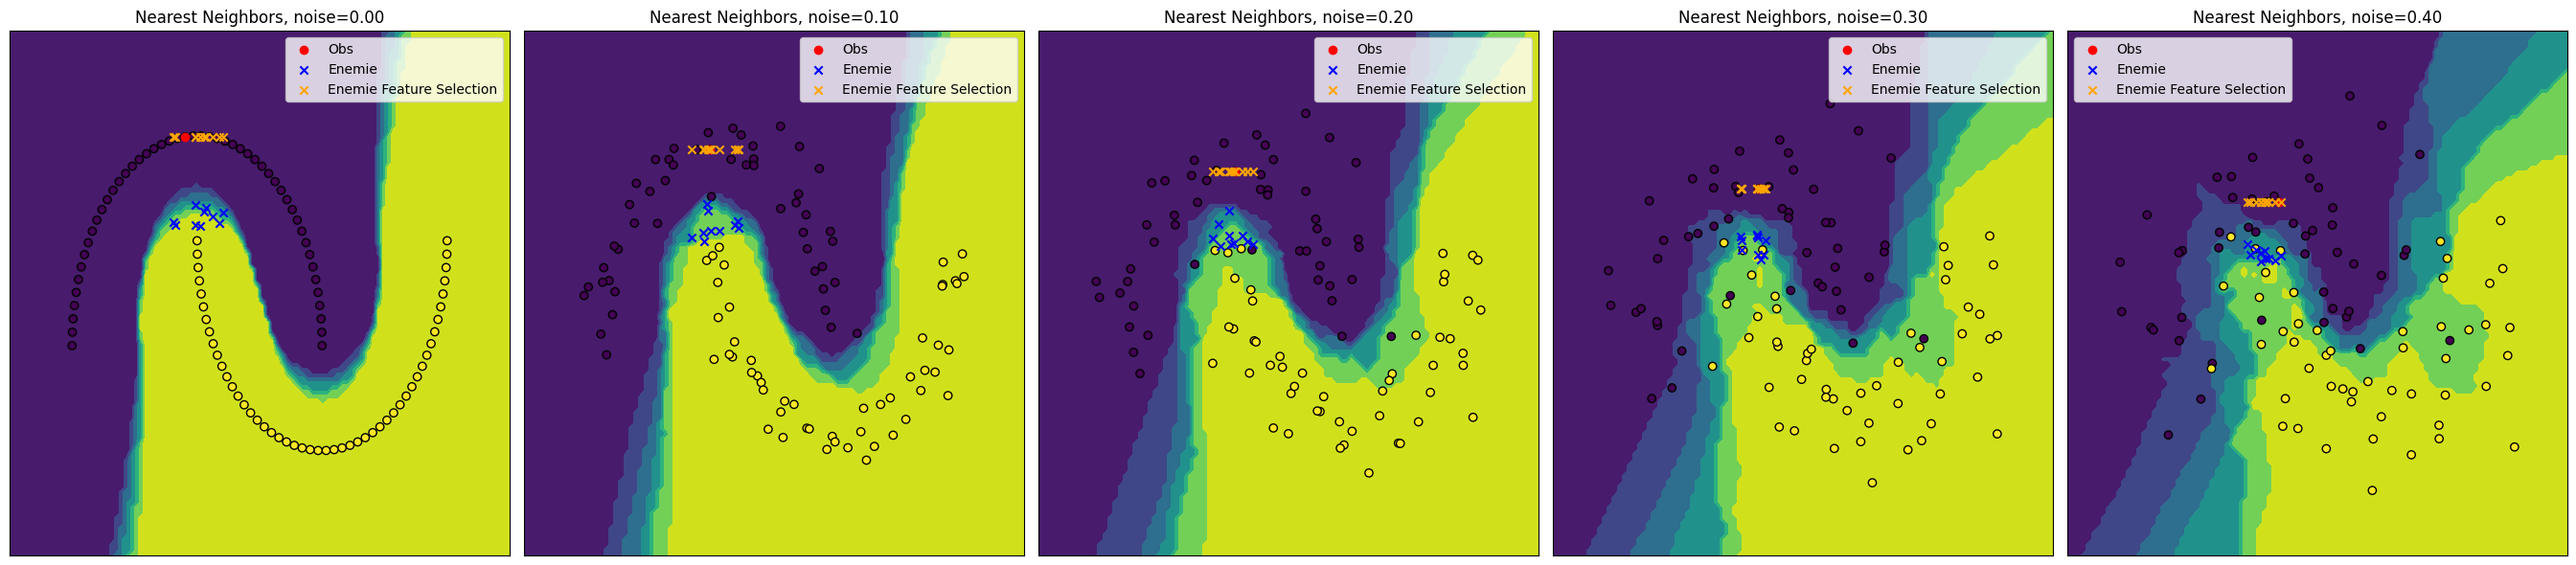

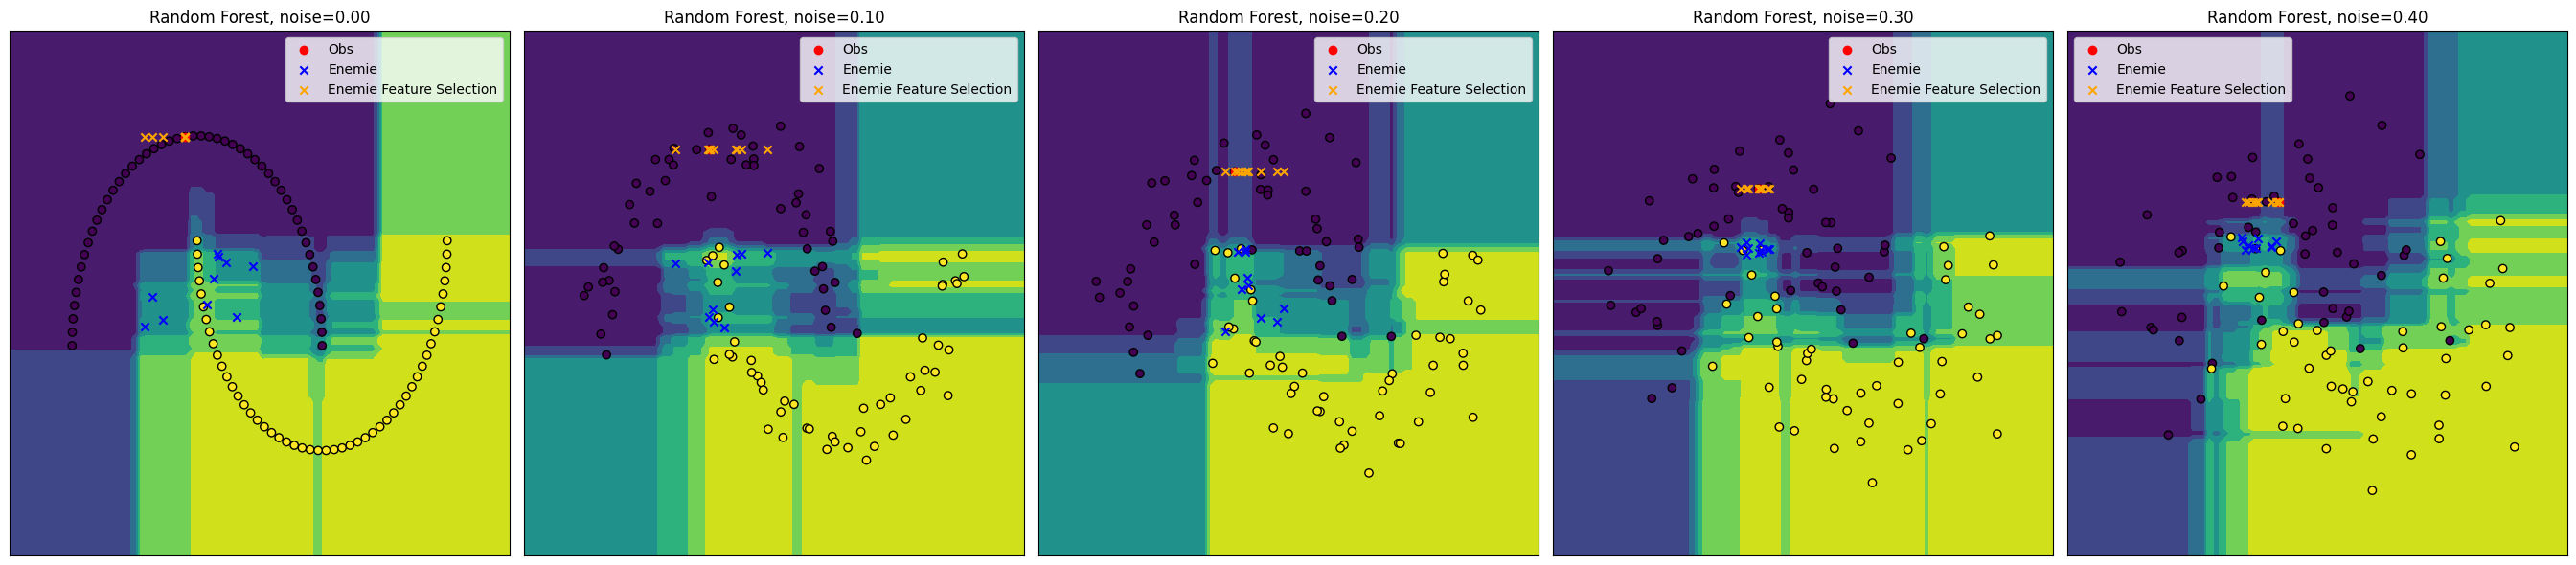

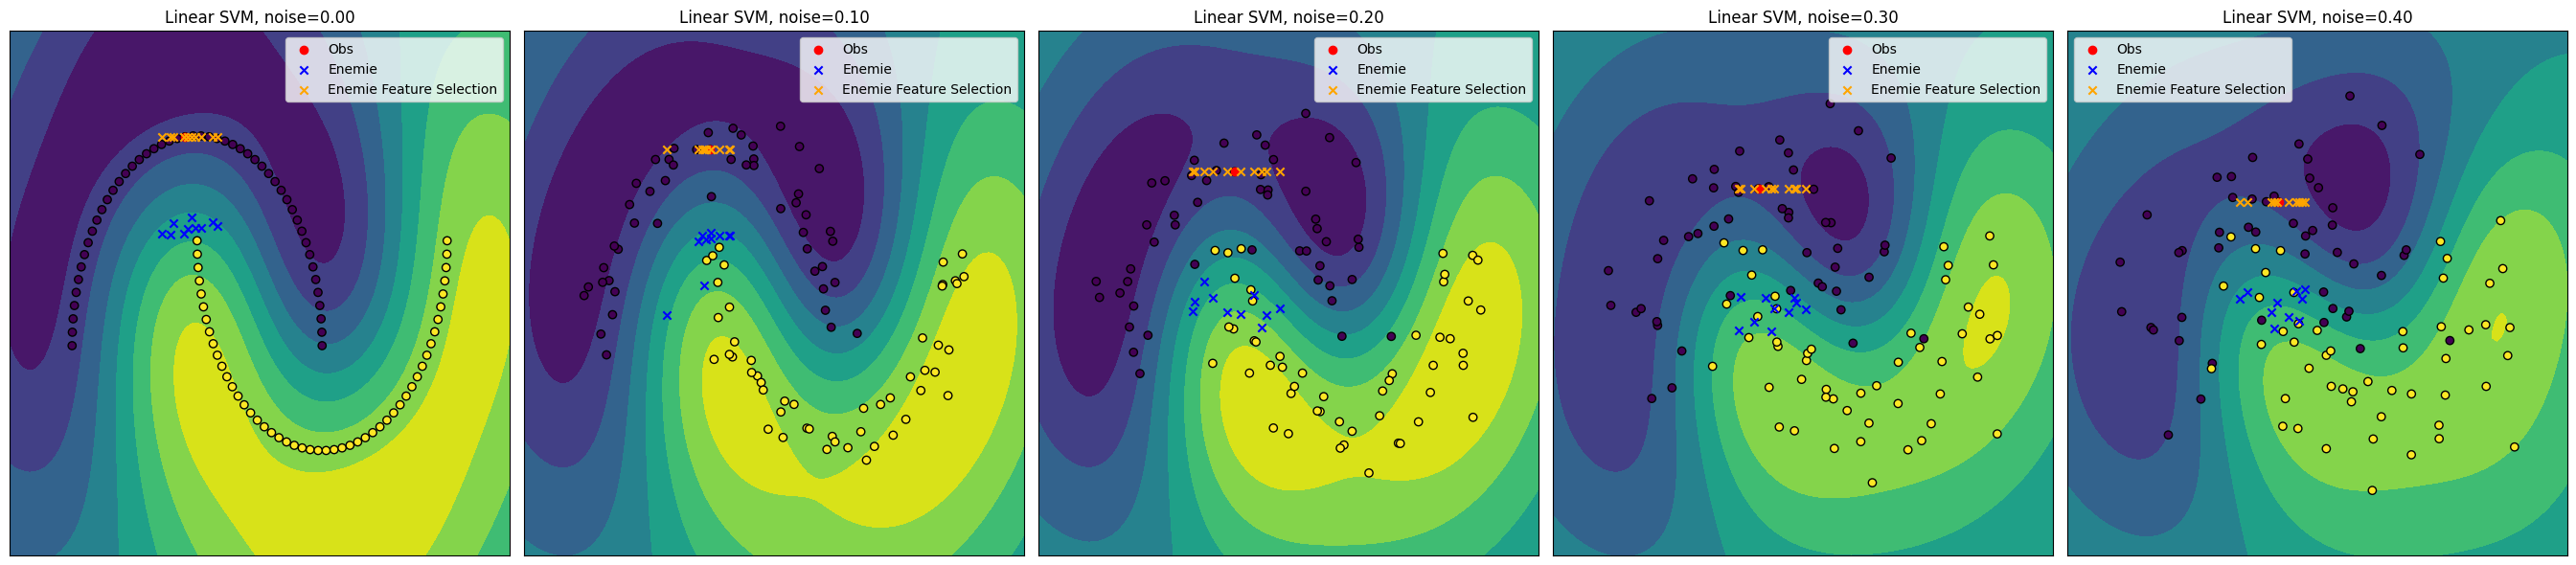

In [4]:
def oui(dataset, clf, n=10, eta=2, n_gs=100, ax=None):
    X, y = dataset
    obs_to_interprete = X[0]
    clf.fit(X, y)

    enemy_list = []
    enemy_fs_list = []
    for _ in range(n):
        gs = GrowingSpheres(clf, eta, n_gs)
        enemy, enemy_fs = gs.predict(obs_to_interprete)
        enemy_list.append(enemy)
        enemy_fs_list.append(enemy_fs)
        
    if not ax:
        _, ax = plt.subplots()
    plot_boundaries(X, y, ax, clf)
    ax.scatter(*obs_to_interprete, c="red", marker='o', label='Obs')
    for enemy, enemy_fs in zip(enemy_list[:-1], enemy_fs_list[:-1]):
        ax.scatter(*enemy, c="blue", marker='x')
        ax.scatter(*enemy_fs, c="orange", marker='x')
    ax.scatter(*enemy_list[-1], c="blue", marker='x', label='Enemie')
    ax.scatter(*enemy_fs_list[-1], c="orange", marker='x', label='Enemie Feature Selection')
    ax.legend()
    return ax

names = [
    "Nearest Neighbors",
    "Random Forest",
    "Linear SVM",
]
classifiers = [
    KNeighborsClassifier(),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    SVC(),
]
# Création de Dataset avec différent niveau de bruit
datasets = []
noise_lvl = []
for noise in np.arange(0, 0.5, 0.1):
    noise_lvl.append(noise)
    datasets.append(make_moons(noise=noise, random_state=0))

for clf, name in zip(classifiers, names):
    fig = plt.figure(figsize=(27, 6))
    for i, (dataset, noise) in enumerate(zip(datasets,noise_lvl)):
        tmp_ax = fig.add_subplot(1, len(datasets), i+1)
        tmp_ax.set_title(f'{name}, noise={noise:.2f}')
        oui(dataset, clf, ax=tmp_ax)
    fig.tight_layout()

**À interpréter**


### Autre dataset jouet


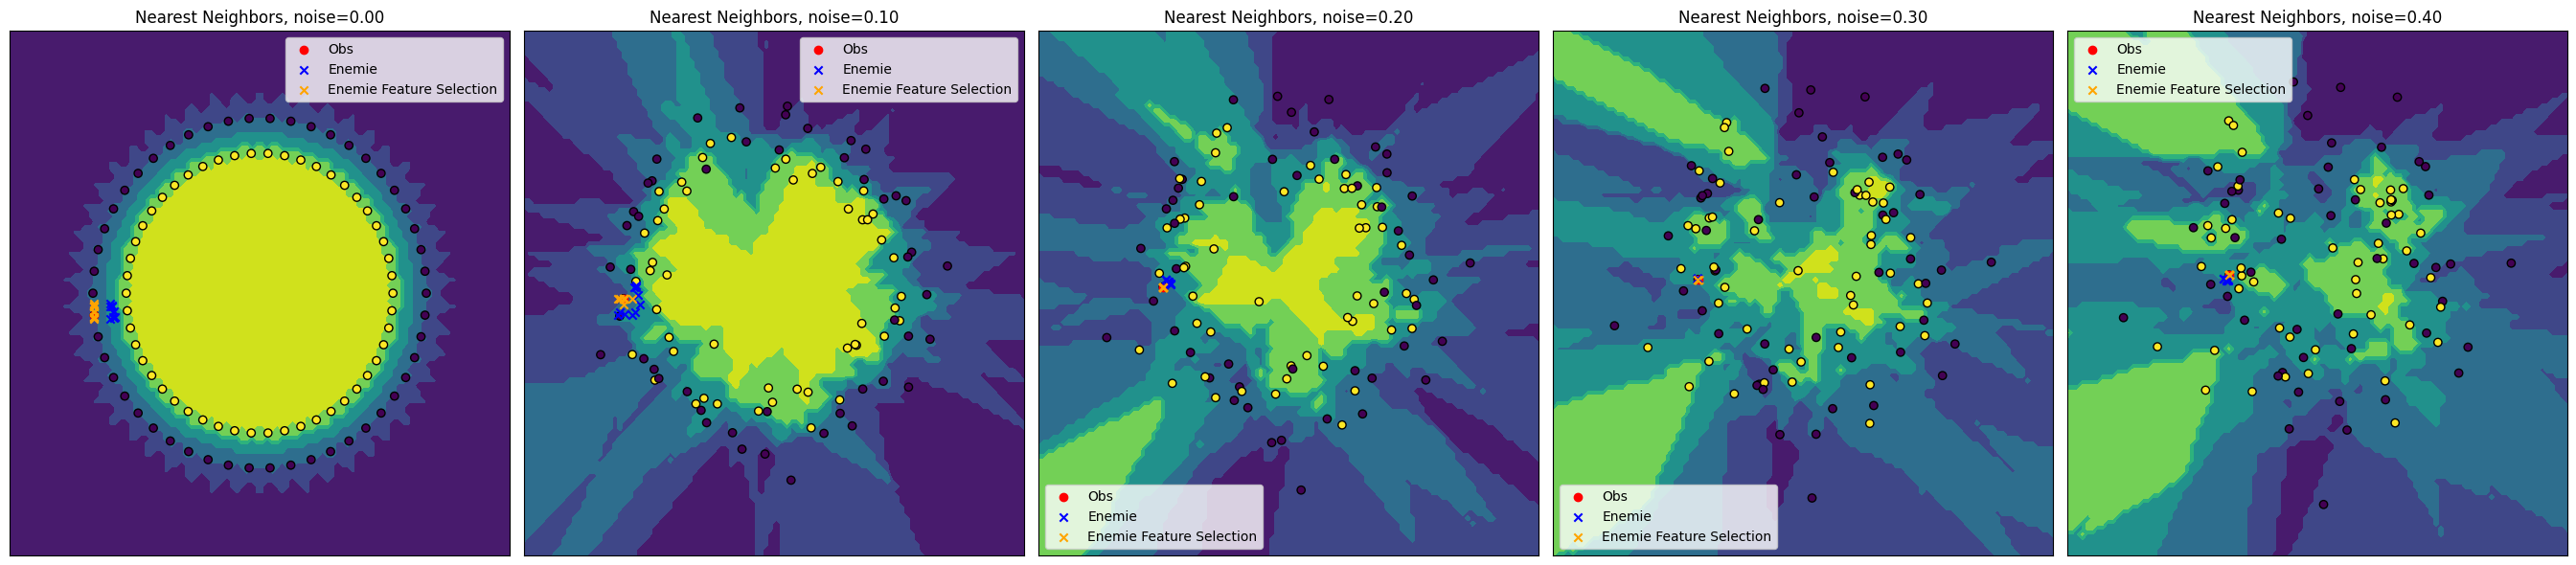

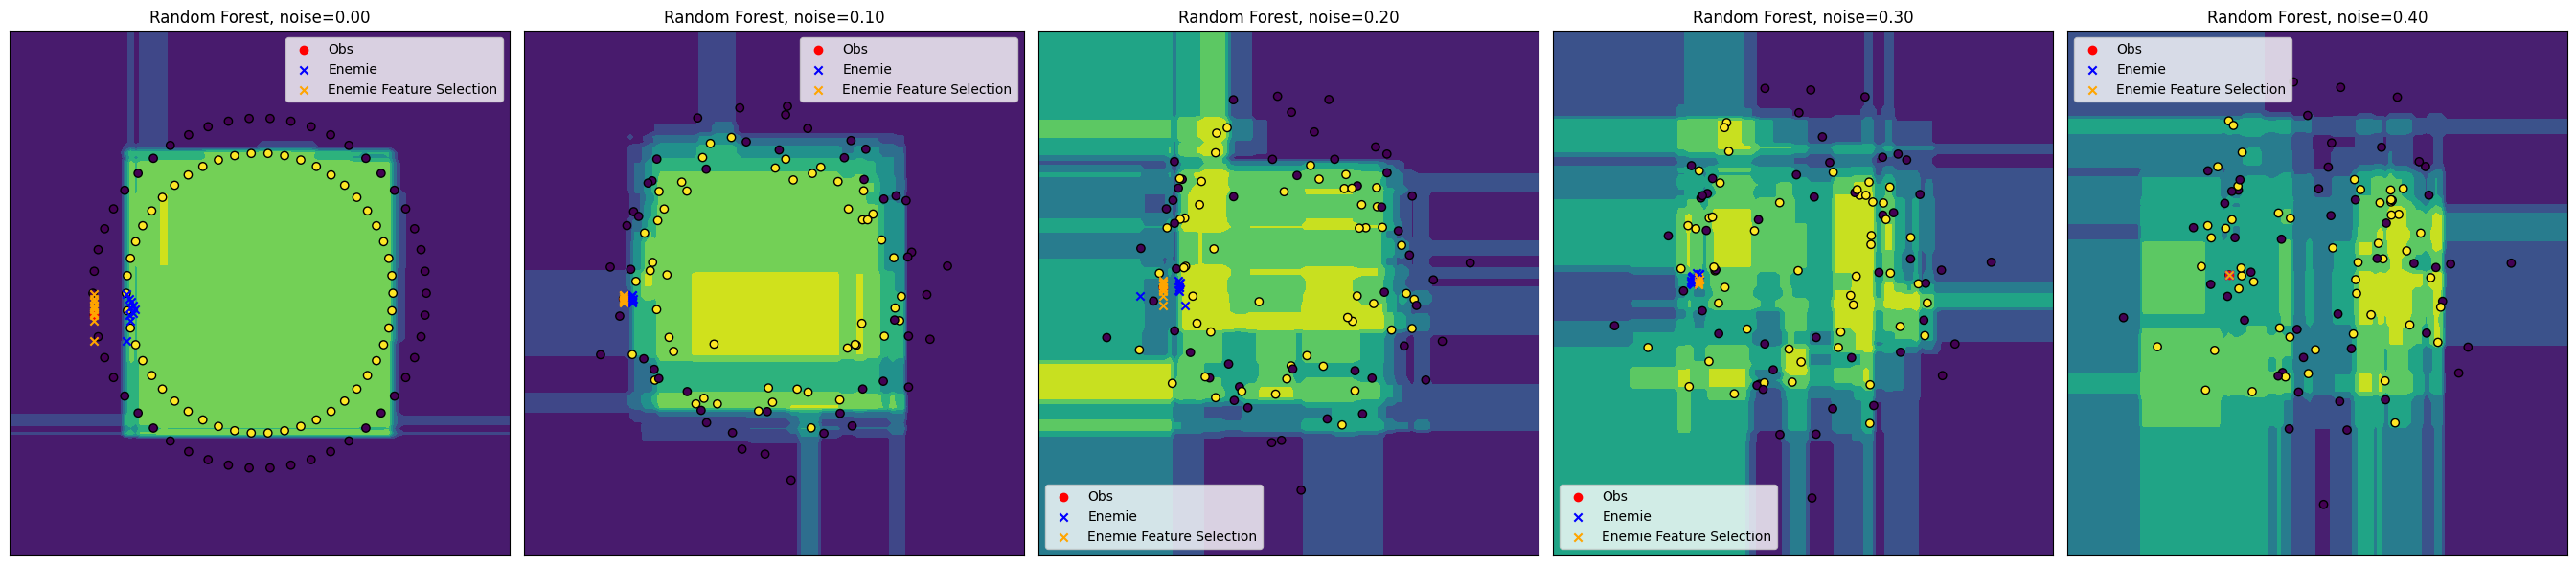

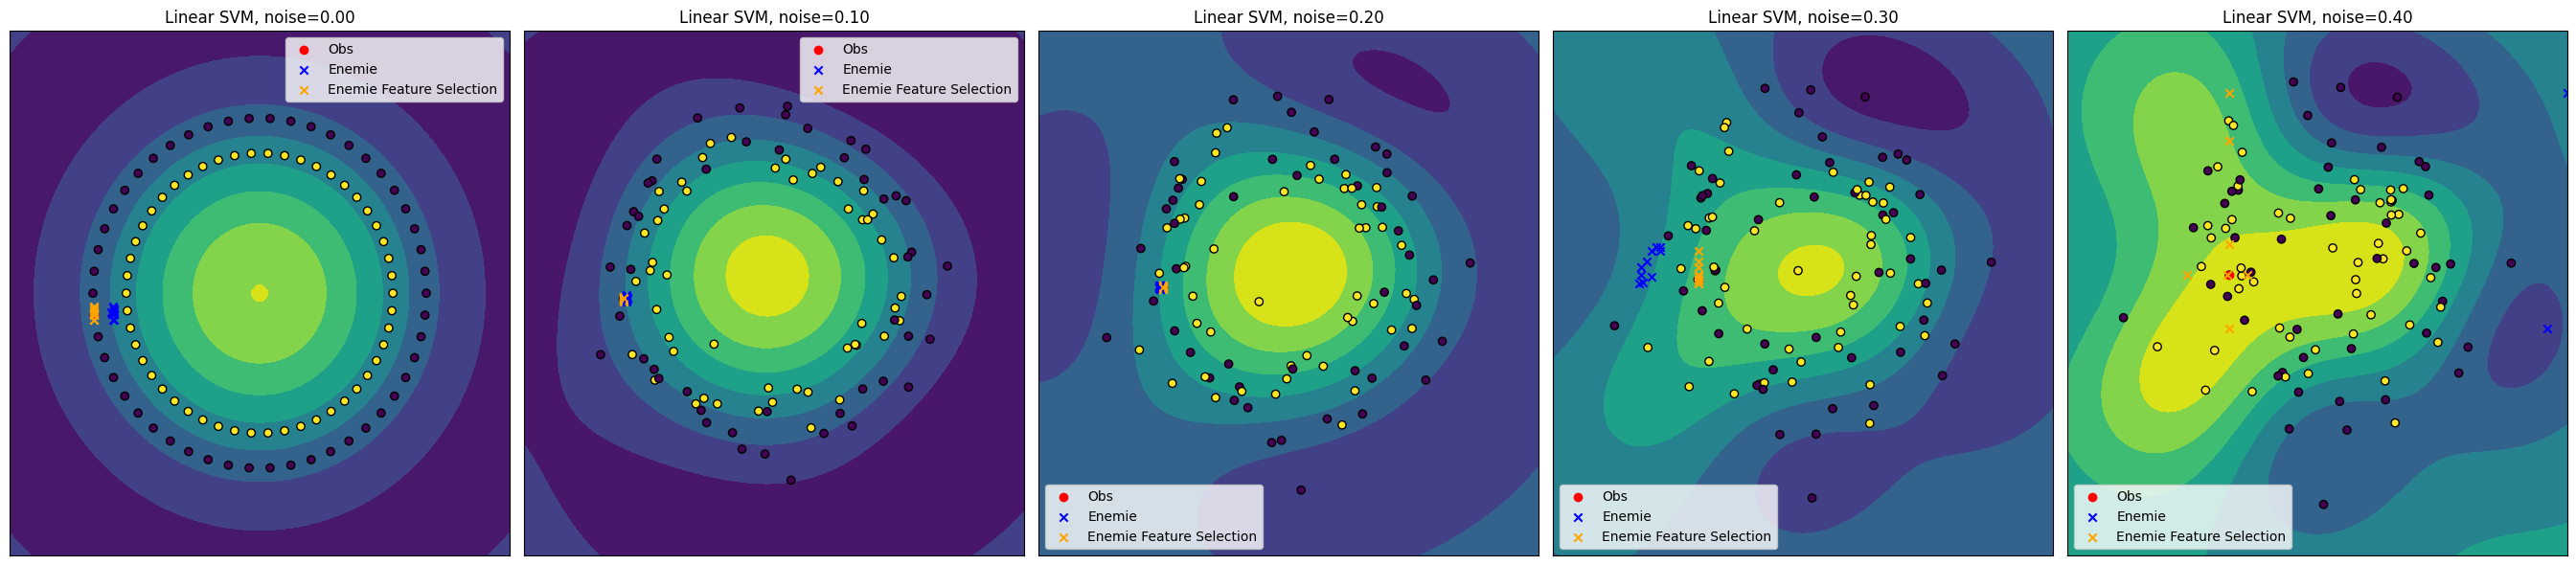

In [5]:
from sklearn.datasets import make_circles
datasets = []
noise_lvl = []
for noise in np.arange(0, 0.5, 0.1):
    noise_lvl.append(noise)
    datasets.append(make_circles(noise=noise, random_state=0))
for clf, name in zip(classifiers, names):
    fig = plt.figure(figsize=(27, 6))
    for i, (dataset, noise) in enumerate(zip(datasets,noise_lvl)):
        tmp_ax = fig.add_subplot(1, len(datasets), i+1)
        tmp_ax.set_title(f'{name}, noise={noise:.2f}')
        oui(dataset, clf, ax=tmp_ax)
    fig.tight_layout()

**Maybe utiliser un autre dataset jouet parce que lui debase les clf l'aimes pas mdr**


### Données classiques


Durant le cours, nous avons particulièrement utilisé l'exemple de l'élégibilité aux prêt bancaire. Nous proposons alors d'utiliser cette exemple pour tester Growing Sphere sur des données réelles. Voici [le dataset](https://www.kaggle.com/datasets/burak3ergun/loan-data-set)

The format of the data:

- Variable Description
- Loan_ID Unique Loan ID
- Gender Male/ Female
- Married Applicant married (Y/N)
- Dependents Number of dependents
- Education Applicant Education (Graduate/ Under Graduate)
- Self_Employed Self employed (Y/N)
- ApplicantIncome Applicant income
- CoapplicantIncome Coapplicant income
- LoanAmount Loan amount in thousands
- Loan_Amount_Term Term of loan in months
- Credit_History Credit history meets guidelines
- Property_Area Urban/ Semi Urban/ Rural
- Loan_Status Loan approved (Y/N)


In [101]:
from sklearn.model_selection import train_test_split
df = pd.read_csv('loan_data_set.csv').drop(columns=['Loan_ID']).dropna().reset_index()
X = df.drop(columns='Loan_Status')
X = pd.get_dummies(X)
y = df['Loan_Status']
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [102]:
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
accuracy_score(y_test,y_pred), accuracy_score(y_train, clf.predict(X_train))

(0.8166666666666667, 0.8194444444444444)

In [103]:
no = y_train == 'N'
accuracy_score(y_train[no], clf.predict(X_train[no]))

0.5043478260869565

In [117]:
from sklearn.model_selection import StratifiedKFold
i=1
mean = 0
kf = StratifiedKFold(n_splits=5,random_state=1,shuffle=True)
for train_index,test_index in kf.split(X,y):
    print ('\n{} of kfold {} '.format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.loc[test_index]
    ytr,yvl = y[train_index],y[test_index]
    model = LogisticRegression(random_state=1)
    model.fit(xtr,ytr)
    pred_test=model.predict(xvl)
    score=accuracy_score(yvl,pred_test)
    no = yvl == 'N'
    score_no=accuracy_score(yvl[no],pred_test[no])
    mean += score
    print ('accuracy_score',score)
    print('acc on refused', score_no)
    i+=1
    # pred_test = model.predict(test)
    # pred = model.predict_proba(xvl)[:,1]
print ('\n Mean Validation Accuracy',mean/(i-1))


1 of kfold 5 
accuracy_score 0.78125
acc on refused 0.4

2 of kfold 5 
accuracy_score 0.7083333333333334
acc on refused 0.43333333333333335

3 of kfold 5 
accuracy_score 0.8020833333333334
acc on refused 0.43333333333333335

4 of kfold 5 
accuracy_score 0.8229166666666666
acc on refused 0.5172413793103449

5 of kfold 5 
accuracy_score 0.71875
acc on refused 0.2413793103448276

 Mean Validation Accuracy 0.7666666666666667


/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#log

In [105]:
y_train[y_train == 'N']

139    N
118    N
226    N
236    N
420    N
      ..
11     N
117    N
284    N
319    N
309    N
Name: Loan_Status, Length: 115, dtype: object

In [106]:
idx = 401
obs_to_interprete = X_train.loc[idx]
y_train[idx], obs_to_interprete

('N',
 index                         514
 ApplicantIncome              5815
 CoapplicantIncome          3666.0
 LoanAmount                  311.0
 Loan_Amount_Term            360.0
 Credit_History                1.0
 Gender_Female               False
 Gender_Male                  True
 Married_No                   True
 Married_Yes                 False
 Dependents_0                 True
 Dependents_1                False
 Dependents_2                False
 Dependents_3+               False
 Education_Graduate           True
 Education_Not Graduate      False
 Self_Employed_No             True
 Self_Employed_Yes           False
 Property_Area_Rural          True
 Property_Area_Semiurban     False
 Property_Area_Urban         False
 Name: 401, dtype: object)

In [107]:
gs = GrowingSpheres(clf, 2, 100)
enemy, enemy_fs = gs.predict(obs_to_interprete.to_numpy())
enemy = pd.Series(enemy, index=obs_to_interprete.index, name='enemy')
enemy_fs = pd.Series(enemy_fs, index=obs_to_interprete.index, name='enemy_fs')

/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/charles/M

In [108]:
pd.DataFrame([obs_to_interprete, enemy_fs, enemy])

,index,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Gender_Female,Gender_Male,Married_No,Married_Yes,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
401,514.000000,5815.000000,3666.000000,311.00000,360.000000,1.000000,False,True,True,False,...,False,False,False,True,False,True,False,True,False,False
enemy_fs,514.008476,5814.999877,3666.004612,310.99743,359.988863,1.000000,-0.006751,True,1.008167,-0.006194,...,-0.000638,-0.006298,-0.003768,0.99786,-0.002942,1.002806,0.000889,1.008293,0.003181,0.01014
enemy,514.008476,5814.999877,3666.004612,310.99743,359.988863,0.988357,-0.006751,1.01416,1.008167,-0.006194,...,-0.000638,-0.006298,-0.003768,0.99786,-0.002942,1.002806,0.000889,1.008293,0.003181,0.01014


In [109]:
print(clf.predict(obs_to_interprete.to_numpy().reshape(1, -1)))
print(clf.predict(enemy.to_numpy().reshape(1, -1)))
print(clf.predict(enemy_fs.to_numpy().reshape(1, -1)))

['Y']
['N']
['Y']


/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/home/charles/M2-DAC/.venv/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
